In [33]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
from numpy import random


In [2]:
data_train = joblib.load('train.joblib')
data_test = joblib.load('eval1.joblib')

In [3]:
#Train images and labels
train_images = data_train['data']
train_labels = data_train['target']
#Test images and labels
test_images = data_test['data']
test_labels = data_test['target']

In [4]:
# Count labels in training set
train_count_0 = np.sum(train_labels == 0)  # Count labels equal to 0
train_count_1 = np.sum(train_labels == 1)  # Count labels equal to 1

print(f"Train Labels - 0: {train_count_0}, 1: {train_count_1}")

# Count labels in test set
test_count_0 = np.sum(test_labels == 0)  # Count labels equal to 0
test_count_1 = np.sum(test_labels == 1)  # Count labels equal to 1

print(f"Test Labels - 0: {test_count_0}, 1: {test_count_1}")

Train Labels - 0: 1100, 1: 1100
Test Labels - 0: 500, 1: 500


In [128]:
# Select a random index
no_images = random.randint(0, train_images.shape[0] - 1)  # Random index within range

# Split the images into two parts
images1 = train_images[:, :5828 // 2]  # First half of the images
images2 = train_images[:, 5828 // 2:]  # Second half of the images

# Reshape the selected images for visualization
image1_reshaped = images1[no_images].reshape(62, 47)  # Reshape to (62, 47)
image2_reshaped = images2[no_images].reshape(62, 47)  # Reshape to (62, 47)

# Get the label for the selected pair
image_label = train_labels[no_images]

# Interpret the label
label_text = "Same" if image_label == 1 else "Different"


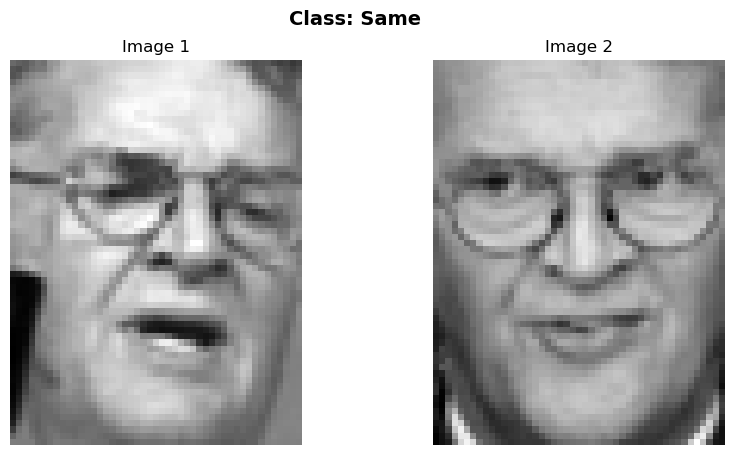

In [129]:
# Plot the images with the label
plt.figure(figsize=(10, 5))

# Image 1
plt.subplot(1, 2, 1)
plt.imshow(image1_reshaped, cmap='gray')
plt.title("Image 1")
plt.axis("off")

# Image 2
plt.subplot(1, 2, 2)
plt.imshow(image2_reshaped, cmap='gray')
plt.title("Image 2")
plt.axis("off")

# Add a super title for the class
plt.suptitle(f"Class: {label_text}", fontsize=14, fontweight='bold')
plt.show()

In [394]:
#Test images
test_images1 = test_images[:, :5828//2]
test_images2 = test_images[:, 5828//2:]

In [395]:
#Pixel-wise distance
pixel_diff = np.abs(images1 - images2)
test_pixel_diff = np.abs(test_images1 - test_images2)
#image pair euclidean distance
euc_dist = np.linalg.norm(images1 - images2, axis=1).reshape(-1, 1)
test_euc_dist = np.linalg.norm(test_images1 - test_images2, axis=1).reshape(-1, 1)

In [396]:
#feature stacking
X_features = np.hstack([pixel_diff, euc_dist])
X_test_features = np.hstack([test_pixel_diff, test_euc_dist])

In [11]:
#Standardise and PCA
#Standardise
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)
X_test_features_scaled = scaler.fit_transform(X_test_features)
#PCA
pca = PCA(n_components=200)  # Adjust based on dataset size
X_features_pca = pca.fit_transform(X_features_scaled)
X_test_features_pca = pca.fit_transform(X_test_features_scaled)

In [12]:
#create y_train, y_test
y_train = train_labels
y_test = test_labels

In [13]:
#SVM pipeline
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),                   
    ('svm', SVC(random_state=1, kernel = 'rbf', probability=True))
])

# Define the parameter grid
param_grid_svm = [
    {
        'pca__n_components': [100, 200, 300],
        'svm__kernel': ['rbf'],  # RBF kernel
        'svm__C': [0.01, 0.1, 1, 10],
        'svm__gamma': [1e-5, 1e-4, 0.001, 0.01]
    },
    {
        'pca__n_components': [100, 200, 300],
        'svm__kernel': ['poly'],  # Polynomial kernel
        'svm__C': [0.01, 0.1, 1, 10],
        'svm__gamma': [1e-5, 1e-4, 0.001, 0.01],
        'svm__degree': [2, 3, 4]  # Degree of the polynomial kernel
    }
]

# Perform Grid Search
grid_search_svm = GridSearchCV(estimator=pipeline_svm, param_grid=param_grid_svm, cv=5, verbose=1, n_jobs=-1)
grid_search_svm.fit(X_features, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_svm.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_svm.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'pca__n_components': 100, 'svm__C': 1, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.6504545454545455


In [14]:
y_train_pred = grid_search_svm.best_estimator_.predict(X_features)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
y_test_pred = grid_search_svm.best_estimator_.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 95.86%
Testing Accuracy: 65.10%


In [15]:
# Random Forest pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('pca', PCA()),               
    ('rf', RandomForestClassifier(random_state=1))  # Random Forest classifier
])

# Define the parameter grid
param_grid_rf = {
    'pca__n_components': [100, 200],  # Dimensionality reduction
    'rf__n_estimators': [100, 200],  # Number of trees in the forest
    'rf__max_depth': [10, 20, 30],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'rf__min_samples_leaf': [2, 4, 8]  # Minimum number of samples required at each leaf node
}

# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_features, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'pca__n_components': 100, 'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best Cross-Validation Accuracy: 0.6495454545454545


In [16]:
# Evaluate on the test set
best_model_rf = grid_search_rf.best_estimator_
y_train_pred_rf = best_model_rf.predict(X_features)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Train Set Accuracy RF: {train_accuracy_rf * 100:.2f}%")

y_test_pred_rf = best_model_rf.predict(X_test_features)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Test Set Accuracy RF: {test_accuracy_rf * 100:.2f}%")

Train Set Accuracy RF: 97.14%
Test Set Accuracy RF: 63.70%


In [22]:
# Define the pipeline
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step (important for distance-based methods)
    ('pca', PCA()),                # PCA for dimensionality reduction
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# Define the parameter grid
param_grid_knn = {
    'pca__n_components': [50,100, 200,300],   # Number of PCA components
    'knn__n_neighbors': [1, 3, 5, 10, 20, 50, 100],    # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weighting function
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Perform Grid Search
grid_search_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_features, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 50, 'knn__weights': 'uniform', 'pca__n_components': 50}
Best Cross-Validation Accuracy: 0.6177272727272728


In [23]:
# Evaluate the best KNN model on the training set
best_model_knn = grid_search_knn.best_estimator_  # Best KNN model from Grid Search
y_train_pred_knn = best_model_knn.predict(X_features)  # Predict on training data
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)  # Calculate training accuracy
print(f"Train Set Accuracy KNN: {train_accuracy_knn * 100:.2f}%")

# Evaluate the best KNN model on the test set
y_test_pred_knn = best_model_knn.predict(X_test_features)  # Predict on testing data
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)  # Calculate testing accuracy
print(f"Test Set Accuracy KNN: {test_accuracy_knn * 100:.2f}%")

Train Set Accuracy KNN: 64.50%
Test Set Accuracy KNN: 62.40%


In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('pca', PCA()),                # PCA for dimensionality reduction
    ('nn', MLPClassifier(max_iter=500, random_state=1))  # Neural Network classifier
])

# Define the parameter grid
param_grid_nn = {
    'pca__n_components': [50, 100, 200, 300],  # Number of PCA components
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 50), (200, 100), (200, 100, 50), (200, 100, 50, 25) ],  # Hidden layer sizes
    'nn__activation': ['relu'],  # Activation functions
    'nn__solver': ['adam'],  # Optimization methods
    'nn__alpha': [0.0001, 0.001, 0.01],
    'nn__early_stopping': [True]
}

# Perform Grid Search
grid_search_nn = GridSearchCV(estimator=pipeline_nn, param_grid=param_grid_nn, cv=5, verbose=1, n_jobs=-1)
grid_search_nn.fit(X_features, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_nn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_nn.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'nn__activation': 'relu', 'nn__alpha': 0.01, 'nn__early_stopping': True, 'nn__hidden_layer_sizes': (200, 100, 50, 25), 'nn__solver': 'adam', 'pca__n_components': 100}
Best Cross-Validation Accuracy: 0.64


In [31]:
# Evaluate the best Neural Network model on the training set
best_model_nn = grid_search_nn.best_estimator_  # Best NN model from Grid Search
y_train_pred_nn = best_model_nn.predict(X_features)  # Predict on training data
train_accuracy_nn = accuracy_score(y_train, y_train_pred_nn)  # Calculate training accuracy
print(f"Train Set Accuracy NN: {train_accuracy_nn * 100:.2f}%")

# Evaluate the best Neural Network model on the test set
y_test_pred_nn = best_model_nn.predict(X_test_features)  # Predict on testing data
test_accuracy_nn = accuracy_score(y_test, y_test_pred_nn)  # Calculate testing accuracy
print(f"Test Set Accuracy NN: {test_accuracy_nn * 100:.2f}%")

Train Set Accuracy NN: 77.91%
Test Set Accuracy NN: 64.10%


### Augmentation

In [370]:
def vflip(image):
    image_aug = ImageOps.flip(image)
    return image_aug

def hflip(image):
    image_aug = ImageOps.mirror(image)
    return image_aug

def brightness(image, min_factor=0.8, max_factor=1.2):
    enhancer = ImageEnhance.Brightness(image)
    factor = np.random.uniform(min_factor, max_factor)
    image_aug =  enhancer.enhance(factor)
    return image_aug

def contrast(image, min_factor=0.8, max_factor=1.2):
    enhancer = ImageEnhance.Contrast(image)
    factor = np.random.uniform(min_factor, max_factor)
    image_aug =  enhancer.enhance(factor)
    return image_aug

def edges(image):
    image_aug = image.filter(ImageFilter.FIND_EDGES)
    return image_aug

def rotate(image1, image2, angles=10):
    angle = np.random.uniform(-angles, angles)  # Generate a single random angle
    image1_aug = image1.rotate(angle)
    image2_aug = image2.rotate(angle)
    return image1_aug, image2_aug

def blur(image, radius=0.5):
    image_aug = image.filter(ImageFilter.GaussianBlur(radius))
    return image_aug

def invert_colours(image):
    image_aug = ImageOps.invert(image)
    return image_aug


In [385]:
def augment_images_set(train_images, train_labels, augmentation, augmented_sets):

    indices = np.random.choice(len(train_images), size=augmented_sets, replace=False)

    augmented_dataset = []
    augmented_labels = []

    for idx in indices:
        pair = train_images[idx]
        label = train_labels[idx]
        
        image1 = Image.fromarray(pair[:2914].reshape(62, 47) * 255).convert("L")
        image2 = Image.fromarray(pair[2914:].reshape(62, 47) * 255).convert("L")

        # Apply augmentation (e.g., rotate both images by the same angle)
        if augmentation == rotate:
            image1_aug, image2_aug = augmentation(image1, image2)  # Pass both images to rotate
        else:
            image1_aug = augmentation(image1)
            image2_aug = augmentation(image2)

        image1_aug_flat = np.array(image1_aug).flatten()
        image2_aug_flat = np.array(image2_aug).flatten()
        
        augmented_pair = np.hstack([image1_aug_flat, image2_aug_flat])
        augmented_dataset.append(augmented_pair)
        augmented_labels.append(label)
    
    # Convert lists to numpy arrays
    augmented_dataset = np.array(augmented_dataset)
    augmented_labels = np.array(augmented_labels)
    return augmented_dataset, augmented_labels

augmented_dataset_vflip, augmented_labels_vflip = augment_images_set(train_images, train_labels,vflip, 100)
augmented_dataset_hflip, augmented_labels_hflip = augment_images_set(train_images, train_labels,hflip, 100)
augmented_dataset_brightness, augmented_labels_brightness = augment_images_set(train_images, train_labels,brightness, 1000)
augmented_dataset_contrast, augmented_labels_contrast = augment_images_set(train_images, train_labels,contrast, 100)
# augmented_dataset_edges, augmented_labels_edges = augment_images_set(train_images, train_labels,edges, 500)
augmented_dataset_rotate, augmented_labels_rotate = augment_images_set(train_images, train_labels,rotate, 100)
# augmented_dataset_blur, augmented_labels_blur = augment_images_set(train_images, train_labels,blur, 150)
# augmented_dataset_invert_colours, augmented_labels_invert_colours = augment_images_set(train_images, train_labels,invert_colours, 150)

augmented_dataset_combined = np.vstack([
    augmented_dataset_vflip,
    augmented_dataset_hflip,
    augmented_dataset_brightness,
    augmented_dataset_contrast,
    # augmented_dataset_edges,
    augmented_dataset_rotate,
    # augmented_dataset_blur,
    # augmented_dataset_invert_colours
])

augmented_labels_combined = np.hstack([
    augmented_labels_vflip,
    augmented_labels_hflip,
    augmented_labels_brightness,
    augmented_labels_contrast,
    # augmented_labels_edges,
    augmented_labels_rotate,
    # augmented_labels_blur,
    # augmented_labels_invert_colours
])

final_train_images = np.vstack([train_images, augmented_dataset_combined])
final_train_labels = np.hstack([train_labels, augmented_labels_combined])

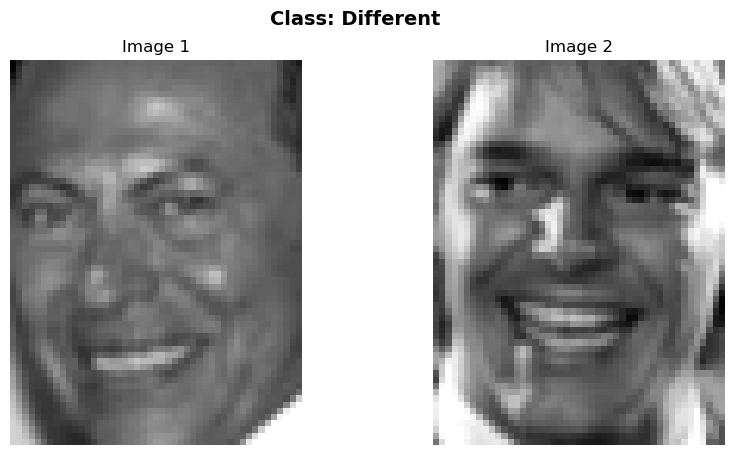

In [386]:
# Select a random index
no_images = random.randint(0, augmented_dataset_combined.shape[0] - 1)  # Random index within range

# Split the images into two parts
images1 = augmented_dataset_combined[:, :5828 // 2]  # First half of the images
images2 = augmented_dataset_combined[:, 5828 // 2:]  # Second half of the images

# Reshape the selected images for visualization
image1_reshaped = images1[no_images].reshape(62, 47)  # Reshape to (62, 47)
image2_reshaped = images2[no_images].reshape(62, 47)  # Reshape to (62, 47)

# Get the label for the selected pair
image_label = augmented_labels_combined[no_images]

# Interpret the label
label_text = "Same" if image_label == 1 else "Different"

# Plot the images with the label
plt.figure(figsize=(10, 5))

# Image 1
plt.subplot(1, 2, 1)
plt.imshow(image1_reshaped, cmap='gray')
plt.title("Image 1")
plt.axis("off")

# Image 2
plt.subplot(1, 2, 2)
plt.imshow(image2_reshaped, cmap='gray')
plt.title("Image 2")
plt.axis("off")

# Add a super title for the class
plt.suptitle(f"Class: {label_text}", fontsize=14, fontweight='bold')
plt.show()

In [387]:
# Count labels in training set
final_train_count_0 = np.sum(final_train_labels == 0)  # Count labels equal to 0
final_train_count_1 = np.sum(final_train_labels == 1)  # Count labels equal to 1

print(f"Train Labels - 0: {final_train_count_0}, 1: {final_train_count_1}")

Train Labels - 0: 1822, 1: 1778


In [388]:
#prep data
# Split the images into two parts
images1_aug = final_train_images[:, :5828 // 2]
images2_aug = final_train_images[:,5828 // 2:]
#Pixel-wise distance
pixel_diff_aug = np.abs(images1_aug - images2_aug)
#image pair euclidean distance
euc_dist_aug = np.linalg.norm(images1_aug - images2_aug, axis=1).reshape(-1, 1)
#feature stacking
X_features_aug = np.hstack([pixel_diff_aug, euc_dist_aug])

In [ ]:
images1_aug = final_train_images[:, :5828 // 2]
images2_aug = final_train_images[:,5828 // 2:]

In [397]:
#Standardise and PCA
#Standardise
scaler = StandardScaler()
X_features_scaled_aug = scaler.fit_transform(X_features_aug)
X_test_features_scaled = scaler.transform(X_test_features)
#PCA
pca = PCA(n_components=50)  # Adjust based on dataset size
X_features_pca_aug = pca.fit_transform(X_features_scaled_aug)
X_test_features_pca = pca.transform(X_test_features_scaled)

In [ ]:
#Train images and labels
train_images = data_train['data']
train_labels = data_train['target']
#Test images and labels
test_images = data_test['data']
test_labels = data_test['target']

In [405]:
#SVM pipeline
# pipeline_svm = Pipeline([
#     ('scaler', StandardScaler()),
#     ('pca', PCA()),                   
#     ('svm', SVC(random_state=1, kernel = 'rbf', probability=True))
# ])

# Define the parameter grid
param_grid_svm = {
        'kernel': ['rbf'],  # RBF kernel
        # 'C': np.logspace(1,1,3),
        # 'gamma': np.logspace(-3,1,1)
    }
# ,
    # {
    #     'pca__n_components': [100, 200, 300],
    #     'svm__kernel': ['poly'],  # Polynomial kernel
    #     'svm__C': [0.01, 0.1, 1, 10],
    #     'svm__gamma': [1e-5, 1e-4, 0.001, 0.01],
    #     'svm__degree': [2, 3, 4]  # Degree of the polynomial kernel
    # }
svm = SVC(random_state=1)

# Perform Grid Search
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, verbose=3, n_jobs=-1, scoring='accuracy')
grid_search_svm.fit(X_features_pca_aug, final_train_labels)

# Best parameters and score
print("Best Parameters:", grid_search_svm.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_svm.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END ........................kernel=rbf;, score=0.494 total time=   0.4s
[CV 3/5] END ........................kernel=rbf;, score=0.494 total time=   0.4s
[CV 1/5] END ........................kernel=rbf;, score=0.494 total time=   0.4s
[CV 5/5] END ........................kernel=rbf;, score=0.585 total time=   0.4s
[CV 4/5] END ........................kernel=rbf;, score=0.585 total time=   0.5s
Best Parameters: {'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.5305555555555556


In [406]:
y_train_pred = grid_search_svm.best_estimator_.predict(X_features_pca_aug)

train_accuracy = accuracy_score(final_train_labels, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_test_pred = grid_search_svm.best_estimator_.predict(X_test_features_pca)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 62.44%
Testing Accuracy: 50.00%


In [ ]:
# Random Forest pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('pca', PCA()),               
    ('rf', RandomForestClassifier(random_state=1))  # Random Forest classifier
])

# Define the parameter grid
param_grid_rf = {
    'pca__n_components': [100, 200],  # Dimensionality reduction
    'rf__n_estimators': [100, 200],  # Number of trees in the forest
    'rf__max_depth': [10, 20, 30],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'rf__min_samples_leaf': [2, 4, 8]  # Minimum number of samples required at each leaf node
}

# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_features_aug, final_train_labels)

# Best parameters and score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'pca__n_components': 200, 'rf__max_depth': 10, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best Cross-Validation Accuracy: 0.6178723404255319


In [ ]:
# Evaluate on the test set
best_model_rf = grid_search_rf.best_estimator_
y_train_pred_rf = best_model_rf.predict(X_features_aug)
train_accuracy_rf = accuracy_score(final_train_labels, y_train_pred_rf)
print(f"Train Set Accuracy RF: {train_accuracy_rf * 100:.2f}%")

y_test_pred_rf = best_model_rf.predict(X_test_features)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Test Set Accuracy RF: {test_accuracy_rf * 100:.2f}%")

Train Set Accuracy RF: 94.04%
Test Set Accuracy RF: 64.70%


In [ ]:
# Define the pipeline
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step (important for distance-based methods)
    ('pca', PCA()),                # PCA for dimensionality reduction
    ('knn', KNeighborsClassifier())  # KNN classifier
])

# Define the parameter grid
param_grid_knn = {
    'pca__n_components': [50,100, 200,300],   # Number of PCA components
    'knn__n_neighbors': [1, 3, 5, 10, 20, 50, 100],    # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weighting function
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Perform Grid Search
grid_search_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search_knn.fit(X_features_aug, final_train_labels)

# Best parameters and score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 10, 'knn__weights': 'uniform', 'pca__n_components': 200}
Best Cross-Validation Accuracy: 0.595531914893617


In [ ]:
# Evaluate the best KNN model on the training set
best_model_knn = grid_search_knn.best_estimator_  # Best KNN model from Grid Search
y_train_pred_knn = best_model_knn.predict(X_features_aug)  # Predict on training data
train_accuracy_knn = accuracy_score(final_train_labels, y_train_pred_knn)  # Calculate training accuracy
print(f"Train Set Accuracy KNN: {train_accuracy_knn * 100:.2f}%")

# Evaluate the best KNN model on the test set
y_test_pred_knn = best_model_knn.predict(X_test_features)  # Predict on testing data
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)  # Calculate testing accuracy
print(f"Test Set Accuracy KNN: {test_accuracy_knn * 100:.2f}%")

Train Set Accuracy KNN: 67.47%
Test Set Accuracy KNN: 59.90%


In [368]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('pca', PCA()),                # PCA for dimensionality reduction
    ('nn', MLPClassifier(max_iter=500, random_state=1))  # Neural Network classifier
])

# Define the parameter grid
param_grid_nn = {
    'pca__n_components': [50, 100, 200, 300],  # Number of PCA components
    'nn__hidden_layer_sizes': [(50,), (100,), (100, 50), (200, 100), (200, 100, 50), (200, 100, 50, 25) ],  # Hidden layer sizes
    'nn__activation': ['relu'],  # Activation functions
    'nn__solver': ['adam'],  # Optimization methods
    'nn__alpha': [0.0001, 0.001, 0.01],
    'nn__early_stopping': [True]
}

# Perform Grid Search
grid_search_nn = GridSearchCV(estimator=pipeline_nn, param_grid=param_grid_nn, cv=5, verbose=1, n_jobs=-1,scoring='accuracy')
grid_search_nn.fit(X_features_aug, final_train_labels)

# Best parameters and score
print("Best Parameters:", grid_search_nn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_nn.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'nn__activation': 'relu', 'nn__alpha': 0.001, 'nn__early_stopping': True, 'nn__hidden_layer_sizes': (200, 100), 'nn__solver': 'adam', 'pca__n_components': 200}
Best Cross-Validation Accuracy: 0.5768085106382979


In [369]:
# Evaluate the best Neural Network model on the training set
best_model_nn = grid_search_nn.best_estimator_  # Best NN model from Grid Search
y_train_pred_nn = best_model_nn.predict(X_features_aug)  # Predict on training data
train_accuracy_nn = accuracy_score(final_train_labels, y_train_pred_nn)  # Calculate training accuracy
print(f"Train Set Accuracy NN: {train_accuracy_nn * 100:.2f}%")

# Evaluate the best Neural Network model on the test set
y_test_pred_nn = best_model_nn.predict(X_test_features)  # Predict on testing data
test_accuracy_nn = accuracy_score(y_test, y_test_pred_nn)  # Calculate testing accuracy
print(f"Test Set Accuracy NN: {test_accuracy_nn * 100:.2f}%")

Train Set Accuracy NN: 76.38%
Test Set Accuracy NN: 52.70%


In [ ]:
# #SVM pipeline images augmented only

# # Define the parameter grid
# param_grid_svm = {
#         'kernel': ['rbf'],
#         'C': [0.01, 0.1, 1, 10, 100, 1000],
#         'gamma': [1e-5, 1e-4, 0.001, 0.01, 0.1, 1],
#     }
# svm = SVC(random_state=1)
# # Perform Grid Search
# grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, verbose=1, n_jobs=-1)
# grid_search_svm.fit(train_images_pca_aug, train_labels_aug)

# # Best parameters and score
# print("Best Parameters:", grid_search_svm.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search_svm.best_score_)

# #SVM result images augmented only

# y_train_pred = grid_search_svm.best_estimator_.predict(train_images_pca_aug)
# train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
# print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# y_test_pred = grid_search_svm.best_estimator_.predict(test_images_pca)
# test_accuracy = accuracy_score(test_labels, y_test_pred)
# print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# # Random Forest pipeline images aug

# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [5],
#     'min_samples_split': [10, 15],
#     'min_samples_leaf': [10, 15]
# }
# rf = RandomForestClassifier(random_state=1)
# # Perform Grid Search
# grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, verbose=1, n_jobs=-1)
# grid_search_rf.fit(train_images_pca_aug, train_labels_aug)

# # Best parameters and score
# print("Best Parameters:", grid_search_rf.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

# #RF images Aug
# y_train_pred = grid_search_rf.best_estimator_.predict(train_images_pca_aug)
# train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
# print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# y_test_pred = grid_search_rf.best_estimator_.predict(test_images_pca)
# test_accuracy = accuracy_score(test_labels, y_test_pred)
# print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# #knn images aug
# param_grid_knn = {
#     'n_neighbors': [1, 3, 5, 10, 20, 50],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan', 'minkowski']
# }
# knn =KNeighborsClassifier()
# # Perform Grid Search
# grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, verbose=1, n_jobs=-1)
# grid_search_knn.fit(train_images_pca_aug, train_labels_aug)

# # Best parameters and score
# print("Best Parameters:", grid_search_knn.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)

# # knn images aug
# y_train_pred = grid_search_knn.best_estimator_.predict(train_images_pca_aug)
# train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
# print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# y_test_pred = grid_search_knn.best_estimator_.predict(test_images_pca)
# test_accuracy = accuracy_score(test_labels, y_test_pred)
# print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# # nn images aug
# param_grid_nn = {
#     'hidden_layer_sizes': [(100,80,60,40,20), (100, 50, 25)],  # Hidden layer sizes
#     'activation': ['relu'],  # Activation functions
#     'solver': ['adam'],  # Optimization methods
#     'alpha': [0.0001, 0.001, 0.01],
#     'early_stopping': [True]
# }

# nn = MLPClassifier()
# # Perform Grid Search
# grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid_nn, cv=5, verbose=1, n_jobs=-1)
# grid_search_nn.fit(train_images_pca_aug, train_labels_aug)

# # Best parameters and score
# print("Best Parameters:", grid_search_nn.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search_nn.best_score_)

# # nn images aug

# y_train_pred = grid_search_nn.best_estimator_.predict(train_images_pca_aug)
# train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
# print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# y_test_pred = grid_search_nn.best_estimator_.predict(test_images_pca)
# test_accuracy = accuracy_score(test_labels, y_test_pred)
# print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
#Image only PCA

#Standardise
scaler = StandardScaler()
train_images_scaled_aug = scaler.fit_transform(train_images_aug)
test_images_scaled = scaler.transform(test_images)
#PCA
pca = PCA(n_components=100)
train_images_pca_aug = pca.fit_transform(train_images_scaled_aug)
test_images_pca = pca.transform(test_images_scaled)

In [ ]:
# # Select a random index
# no_images = random.randint(0, augmented_dataset_sharpness.shape[0] - 1)  # Random index within range

# # Split the images into two parts
# images1 = augmented_dataset_sharpness[:, :5828 // 2]  # First half of the images
# images2 = augmented_dataset_sharpness[:, 5828 // 2:]  # Second half of the images

# # Reshape the selected images for visualization
# image1_reshaped = images1[no_images].reshape(62, 47)  # Reshape to (62, 47)
# image2_reshaped = images2[no_images].reshape(62, 47)  # Reshape to (62, 47)

# # Get the label for the selected pair
# image_label = augmented_labels_sharpness[no_images]

# # Interpret the label
# label_text = "Same" if image_label == 1 else "Different"

# # Plot the images with the label
# plt.figure(figsize=(10, 5))

# # Image 1
# plt.subplot(1, 2, 1)
# plt.imshow(image1_reshaped, cmap='gray')
# plt.title("Image 1")
# plt.axis("off")

# # Image 2
# plt.subplot(1, 2, 2)
# plt.imshow(image2_reshaped, cmap='gray')
# plt.title("Image 2")
# plt.axis("off")

# # Add a super title for the class
# plt.suptitle(f"Class: {label_text}", fontsize=14, fontweight='bold')
# plt.show()

In [ ]:
#SVM pipeline Augmented and Features Engineered Train Val
# Define the parameter grid
param_grid_svm = {
        'kernel': ['rbf'],
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.001, 0.01, 0.1, 1],
    }
svm = SVC(random_state=1)
# Perform Grid Search
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, verbose=1, n_jobs=-1)
grid_search_svm.fit(X_train_pca, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_svm.best_params_)

y_train_pred = grid_search_svm.best_estimator_.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_val_pred = grid_search_svm.best_estimator_.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_test_pred = grid_search_svm.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Random Forest pipeline Aug+features

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [10, 15]
}
rf = RandomForestClassifier(random_state=1)
# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train_pca, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

#RF Aug+Features
y_train_pred = grid_search_rf.best_estimator_.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_val_pred = grid_search_rf.best_estimator_.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_test_pred = grid_search_rf.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1],  # Learning rate
    'max_depth': [4],            # Maximum depth of individual trees
    'min_samples_split': [10, 15],  # Minimum samples to split a node
    'min_samples_leaf': [10, 15]    # Minimum samples in a leaf node
}

# Initialize Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=1)

# Perform Grid Search with 5-fold cross-validation
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, verbose=3, n_jobs=-1)
grid_search_gb.fit(X_train_pca, y_train)

# Best parameters and cross-validation score
print("Best Parameters:", grid_search_gb.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_gb.best_score_)

# Evaluate on Training Data
y_train_pred = grid_search_gb.best_estimator_.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on Validation Data
y_val_pred = grid_search_gb.best_estimator_.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate on Test Data
y_test_pred = grid_search_gb.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 10, 20, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn =KNeighborsClassifier()
# Perform Grid Search
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train_pca, y_train)

# Best parameters and score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)

#RF Aug+Features
y_train_pred = grid_search_knn.best_estimator_.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_val_pred = grid_search_knn.best_estimator_.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_test_pred = grid_search_knn.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# nn aug+features

param_grid_nn = {
    'hidden_layer_sizes': [(60), (120, 50, 20), (50, 25), (50,), (25,), (30,)],  # Hidden layer sizes
    'activation': ['relu'],  # Activation functions
    'solver': ['adam'],  # Optimization methods
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True]
}

nn = MLPClassifier()
# Perform Grid Search
grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid_nn, cv=5, verbose=1, n_jobs=-1)
grid_search_nn.fit(train_features_pca_aug, train_labels_aug)

# Best parameters and score
print("Best Parameters:", grid_search_nn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_nn.best_score_)

#RF Aug+Features
y_train_pred = grid_search_nn.best_estimator_.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_val_pred = grid_search_nn.best_estimator_.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_test_pred = grid_search_nn.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# nn aug+features

param_grid_nn = {
    'hidden_layer_sizes': [(40), (120, 50, 20), (50, 25), (50,), (25,), (30,)],  # Hidden layer sizes
    'activation': ['relu'],  # Activation functions
    'solver': ['adam'],  # Optimization methods
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True]
}

nn = MLPClassifier()
# Perform Grid Search
grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid_nn, cv=5, verbose=1, n_jobs=-1)
grid_search_nn.fit(train_features_pca_aug, train_labels_aug)

# Best parameters and score
print("Best Parameters:", grid_search_nn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_nn.best_score_)

# nn aug + features
y_train_pred = grid_search_nn.best_estimator_.predict(train_features_pca_aug)
train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_test_pred = grid_search_nn.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
#knn aug + features
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 10, 20, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn =KNeighborsClassifier()
# Perform Grid Search
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(train_features_pca_aug, train_labels_aug)

# Best parameters and score
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)

#knn aug+features
y_train_pred = grid_search_knn.best_estimator_.predict(train_features_pca_aug)
train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

y_test_pred = grid_search_knn.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100,200],      # Number of boosting stages
    'learning_rate': [0.01],  # Learning rate
    'max_depth': [4],            # Maximum depth of individual trees
    'min_samples_split': [15, 20],  # Minimum samples to split a node
    'min_samples_leaf': [15, 20]    # Minimum samples in a leaf node
}

# Initialize Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=1)

# Perform Grid Search with 5-fold cross-validation
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, verbose=1, n_jobs=-1)
grid_search_gb.fit(train_features_pca_aug, train_labels_aug)

# Best parameters and cross-validation score
print("Best Parameters:", grid_search_gb.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_gb.best_score_)

# Evaluate on Training Data
y_train_pred = grid_search_gb.best_estimator_.predict(train_features_pca_aug)
train_accuracy = accuracy_score(train_labels_aug, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on Test Data
y_test_pred = grid_search_gb.best_estimator_.predict(test_features_pca)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")